In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import folium
from folium import plugins
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap, rgb_to_hsv, hsv_to_rgb
from PIL import Image, ImageDraw, ImageFont
import scipy.ndimage.filters
import io
os.environ["PATH"] += os.pathsep + "."

In [2]:
folder = 'E:\KCL\Project\Cycle Hire 2021\Weekly 2022'
df = []
for file in os.listdir(folder):
    if file.endswith('.csv'):
        df.append(pd.read_csv(os.path.join(folder,file)))
journey = pd.concat(df)
journey.head()

Rental Id  Duration  Bike Id          End Date  EndStation Id  \
0  115967515      1260    15338  01-01-2022 23:13            310   
1  116017034       720    19861  04-01-2022 19:08             11   
2  116016563       480    19861  04-01-2022 18:46            804   
3  116014412      1260    17235  04-01-2022 17:45             14   
4  116013350       480    13790  04-01-2022 16:50            252   

                  EndStation Name        Start Date  StartStation Id  \
0     Black Prince Road, Vauxhall  01-01-2022 22:52              529   
1    Brunswick Square, Bloomsbury  04-01-2022 18:56              804   
2        Good's Way, King's Cross  04-01-2022 18:38               57   
3  Belgrove Street , King's Cross  04-01-2022 17:24              297   
4     Jubilee Gardens, South Bank  04-01-2022 16:42              310   

                     StartStation Name  EndStation Latitude  \
0                Manresa Road, Chelsea              51.4909   
1             Good's Way, King's Cross              51.5240   
2         Guilford Street , Bloomsbury              51.5347   
3  Geraldine Street, Elephant & Castle              51.5299   
4          Black Prince Road, Vauxhall              51.5046   

   EndStation Longitude  StartStation Latitude  StartStation Longitude  
0             -0.116912                51.4869               -0.170983  
1             -0.122502                51.5347               -0.125079  
2             -0.125079                51.5233               -0.120203  
3             -0.123617                51.4961               -0.106001  
4             -0.116542                51.4909               -0.116912

In [3]:
journey['Start Date Time'] = pd.to_datetime(journey['Start Date'], format= '%d-%m-%Y %H:%M')
journey['End Date Time'] = pd.to_datetime(journey['Start Date'], format= '%d-%m-%Y %H:%M')
journey['Hour'] = journey['Start Date Time'].dt.hour

In [4]:
London = [51.506949, -0.122876]
base_map = folium.Map(location= London, zoom_start=12, tiles="CartoDB dark_matter")
folium.CircleMarker(location=London,fill=True).add_to(base_map)
base_map

In [5]:
def get_trip_counts_by_hour(selected_hour, bike_data):
    # make a DataFrame with locations for each bike station

    locations = journey.groupby("StartStation Id").first()
    locations = locations.loc[:, ["StartStation Latitude", "StartStation Longitude", "StartStation Name"]]

    #select one time of day
    hour_selected = journey[journey["Hour"]==selected_hour]
    
    # count trips for each destination
    departure_counts =  hour_selected.groupby("StartStation Id").count().iloc[:,[0]]
    departure_counts.columns= ["Departure Count"]
    
    # count trips for each origin
    arrival_counts =  hour_selected.groupby("EndStation Id").count().iloc[:,[0]]
    arrival_counts.columns= ["Arrival Count"]

    #join departure counts, arrival counts, and locations
    trip_counts = departure_counts.join(locations).join(arrival_counts)
    return trip_counts

In [6]:
def plot_station_counts(trip_counts, zoom_start):
    # generate a new map
    Map = folium.Map(location=London, zoom_start=zoom_start, tiles="CartoDB dark_matter", width='100%')

    # for each row in the data, add a cicle marker
    for index, row in trip_counts.iterrows():
        # calculate net departures
        net_departures = (row["Departure Count"]-row["Arrival Count"])
        
        # generate the popup message that is shown on click.
        popup_text = "{}<br> total departures: {}<br> total arrivals: {}<br> net departures: {}"
        popup_text = popup_text.format(row["StartStation Name"], row["Arrival Count"], row["Departure Count"], net_departures)
        
        # radius of circles
        radius = net_departures/20
        
        # choose the color of the marker
        if net_departures>0:
            color= "#00FF00" #green
        else:            
            color="#FF0000" #red
        
        # add marker to the map
        folium.CircleMarker(location=(row["StartStation Latitude"], row["StartStation Longitude"]), radius=radius,
                            color=color, popup=popup_text, fill=True).add_to(Map)
    return Map

In [7]:
# plot net departures at 9AM

trip_counts = get_trip_counts_by_hour(9, journey)
plot_station_counts(trip_counts, zoom_start= 13)

In [8]:
# plot net departures at 6PM

trip_counts = get_trip_counts_by_hour(18, journey)
plot_station_counts(trip_counts, zoom_start= 13)

In [9]:
def interpolate(df1, df2, x):
    #return a weighted average of two dataframes
    df = df1 * (1 - x) + df2 * x
    return df.replace(np.nan, 0)


def get_trip_counts_by_minute(float_hour, data):
    #get an interpolated dataframe for any time, based on hourly data
    
    columns = ["StartStation Latitude", "StartStation Longitude", "Departure Count", "Arrival Count"]
    df1 = get_trip_counts_by_hour(int(float_hour), data)
    df2 = get_trip_counts_by_hour(int(float_hour) + 1, data)
    
    df = interpolate(df1.loc[:,columns], df2.loc[:,columns], float_hour % 1)
    
    df["StartStation Name"] = df1["StartStation Name"]
    return df

In [10]:
plot_station_counts(get_trip_counts_by_minute(9.5, journey), zoom_start=13)

In [11]:
def go_arrivals_frame(i, hour_of_day, save_path):
    
    # create the map object
    data = get_trip_counts_by_minute(hour_of_day, journey)
    my_frame = plot_station_counts(data, zoom_start = 13)
    
    # generate the png file as a byte array
    png = my_frame._to_png()
    
    #  now add a caption to the image to indicate the time-of-day.
    hour = int(hour_of_day)
    minutes = int((hour_of_day % 1) * 60)
    
    # create a PIL image object
    image = Image.open(io.BytesIO(png))
    draw = ImageDraw.ImageDraw(image)
    
    # load a font
    font = ImageFont.truetype("arial.ttf", 30)
    
    # draw time of day text
    draw.text((20,image.height - 50), "time: {:0>2}:{:0>2}h".format(hour, minutes), fill=(255, 255, 255), font=font)
    
    # draw title
    draw.text((image.width - 400,20), "Net Arrivals vs Time of Day", fill=(255, 255, 255), font=font)
    
    # write to a png file
    filename = os.path.join(save_path, "frame_{:0>5}.png".format(i))
    image.save(filename, "PNG")
    return image

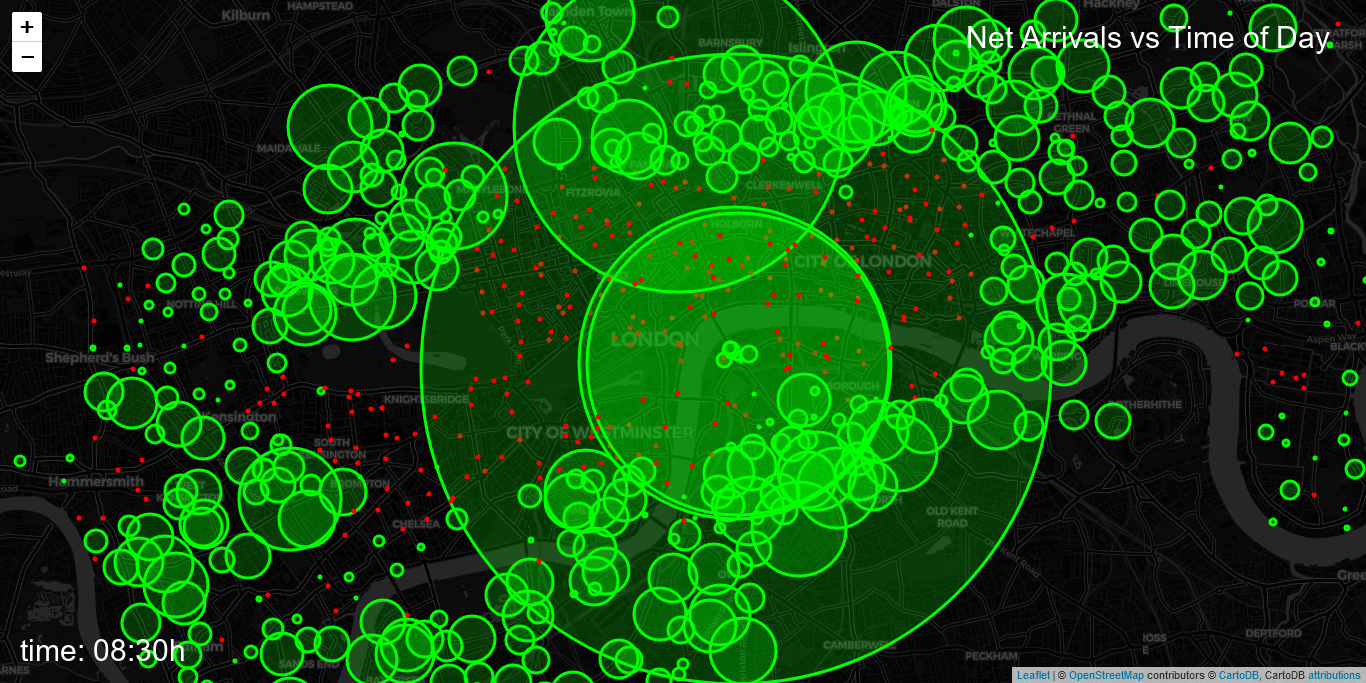

In [14]:
dir_name = 'frames'
if not os.path.exists(dir_name):
    os.mkdir(dir_name)
go_arrivals_frame(1, 8.5, dir_name)

In [ ]:
#arrival_times = np.arange(6, 23, .2)
#for i, hour in enumerate(arrival_times):
#    go_arrivals_frame(i, hour, "frames")